In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.ensemble
import sklearn.linear_model
import sklearn.tree

from copy import deepcopy

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями

Загрузим датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмем из него первые 10к объектов, оставим только вещественные признаки, а пропуски заменим нулями. Разобьем выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оценим качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [2]:
FILE_NAME= 'train.csv'
COUNT_OBJECTS = 10000

data = pd.read_csv(FILE_NAME, nrows=COUNT_OBJECTS)
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [3]:
data.shape

(10000, 133)

In [4]:
target = data["target"]
target.value_counts()

1    7562
0    2438
Name: target, dtype: int64

In [5]:
data.dtypes.value_counts()

float64    108
object      19
int64        6
dtype: int64

In [6]:
all_numerical_column_names = list(filter(lambda elem : data[elem].dtype == 'float64',  data.columns))

In [7]:
num_data = data.loc[:, all_numerical_column_names].fillna(0)
num_data.head()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v120,v121,v122,v123,v124,v126,v127,v128,v130,v131
0,1.335739,8.727474,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,...,1.059603,0.803572,8.000000,1.989780,0.035754,1.804126,3.113719,2.024285,0.636365,2.857144
1,0.000000,0.000000,0.000000,9.191265,0.000000,0.000000,2.301630,0.000000,1.312910,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.598896,0.000000,0.000000,1.957825,0.000000,0.000000
2,0.943877,5.310079,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,...,2.138728,2.238806,9.333333,2.477596,0.013452,1.773709,3.922193,1.120468,0.883118,1.176472
3,0.797415,8.304757,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,...,1.166281,1.956521,7.018256,1.812795,0.002267,1.415230,2.954381,1.990847,1.677108,1.034483
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050328,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
target = data['target']

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(num_data, target, train_size=0.7, random_state=999)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model_DT = DecisionTreeClassifier(max_depth=10)
model_DT_cross = cross_val_score(model_DT, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_DT_cross))

0.7142870697772592


In [11]:
# BaggingClassifier со 100 деревьями
from sklearn.ensemble import BaggingClassifier

model_Bagging = BaggingClassifier(n_estimators=100, n_jobs=-1)
model_Bagging_cross = cross_val_score(model_Bagging, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Bagging_cross))

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/lib/python3.6/site-packages/sklear

0.7507139286515775


In [15]:
# RandomForestClassifier со 100 деревьями

from sklearn.ensemble import RandomForestClassifier

model_Forest = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
model_Forest_cross = cross_val_score(model_Forest, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
# print(np.mean(model_Forest_cross))
print(model_Forest)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### Число деревьев в случайном лесе
В этой задаче рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

Переберем значения от 20 до 1000-5000 деревьев с шагом 50, посчитаем accuracy на тестовой выборке для каждого числа деревьев и построем график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 70 + \ldots + 5000$ деревьев, но можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [22]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

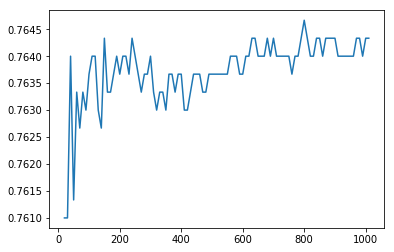

In [27]:
trees_num = 1020
model_Forest = RandomForestClassifier(max_depth=10, n_jobs=-1, warm_start=True)
accuracies = []
for i in range(20, trees_num, 10):
    model_Forest.set_params(n_estimators=i)
    # x_train, x_test, y_train, y_test
    model_Forest.fit(x_train, y_train)
    y_pred = model_Forest.predict(x_test)
    r = accuracy_score(y_test, y_pred)
    accuracies.append(r)

plt.plot([i for i in range(20, trees_num, 10)], accuracies)

#### Обучение градиентного бустинга

А теперь попробуем обучить на тех же данных catboost — одну из реализаций градиентного бустинга. Подберем параметры на обучающем множестве с помощью кросс-валидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров). 

In [29]:
from catboost import CatBoostClassifier

In [33]:
model_Cat = CatBoostClassifier(iterations=700, verbose=False, thread_count=4)
model_Cat_cross = cross_val_score(model_Cat, x_train, y_train, cv=3, n_jobs=-1, scoring='accuracy')
print(np.mean(model_Cat_cross))


Learning rate set to 0.035602
Learning rate set to 0.0356
Learning rate set to 0.035602
0.7595709902491885


_____

In [18]:
x_train, x_test, y_train, y_test = train_test_split()

In [20]:
# metrics
from sklearn.metrics import f1_score, recall_score, precision_score

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавим категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберем в каждом из случаев оптимальные параметры метода. Должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

In [469]:
FILE_NAME= 'train.csv'
COUNT_OBJECTS = 10000
data = pd.read_csv(FILE_NAME, nrows=COUNT_OBJECTS)

target = data["target"]
data = data.drop(["target"], axis=1)

data.dtypes.value_counts()

float64    108
object      19
int64        5
dtype: int64

In [470]:
all_numerical_column_names = list(filter(lambda elem : data[elem].dtype == 'float64',  data.columns))
all_int_column_names = list(filter(lambda elem : data[elem].dtype == 'int64',  data.columns))
all_object_column_names = list(filter(lambda elem : data[elem].dtype == 'object',  data.columns))